# Import Libraries

In [1]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Download Data

In [2]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

# Plot Examples

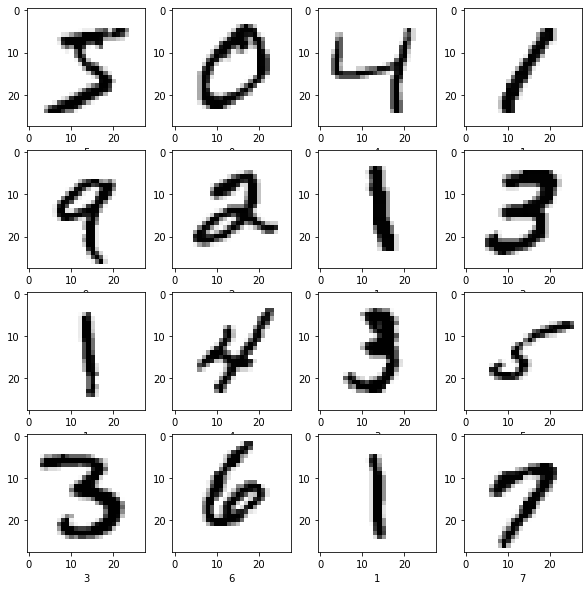

In [4]:
plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_train[i],cmap="binary")
    plt.xlabel(str(y_train[i]))
plt.show()

# Normalize Data

In [9]:
x_train=np.reshape(x_train,(60000,28*28))
x_test=np.reshape(x_test,(10000,28*28))

x_train=x_train/255.
x_test=x_test/255.

# Create a Neural Network Model

In [12]:
model=tf.keras.models.Sequential(
    [tf.keras.layers.Dense(32,activation="sigmoid",input_shape=(784,)),
    tf.keras.layers.Dense(32,activation="sigmoid"),
    tf.keras.layers.Dense(10,activation="softmax")
    ])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
    
)


# Train the Model

In [14]:
_=model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=20,batch_size=1048,verbose=2
)

Epoch 1/20
58/58 - 0s - loss: 0.3455 - accuracy: 0.9162 - val_loss: 0.3280 - val_accuracy: 0.9190
Epoch 2/20
58/58 - 0s - loss: 0.3207 - accuracy: 0.9199 - val_loss: 0.3069 - val_accuracy: 0.9225
Epoch 3/20
58/58 - 0s - loss: 0.2999 - accuracy: 0.9238 - val_loss: 0.2888 - val_accuracy: 0.9260
Epoch 4/20
58/58 - 0s - loss: 0.2827 - accuracy: 0.9276 - val_loss: 0.2738 - val_accuracy: 0.9288
Epoch 5/20
58/58 - 0s - loss: 0.2685 - accuracy: 0.9297 - val_loss: 0.2609 - val_accuracy: 0.9305
Epoch 6/20
58/58 - 0s - loss: 0.2557 - accuracy: 0.9329 - val_loss: 0.2505 - val_accuracy: 0.9323
Epoch 7/20
58/58 - 0s - loss: 0.2445 - accuracy: 0.9353 - val_loss: 0.2409 - val_accuracy: 0.9349
Epoch 8/20
58/58 - 0s - loss: 0.2348 - accuracy: 0.9375 - val_loss: 0.2314 - val_accuracy: 0.9366
Epoch 9/20
58/58 - 0s - loss: 0.2257 - accuracy: 0.9396 - val_loss: 0.2241 - val_accuracy: 0.9383
Epoch 10/20
58/58 - 0s - loss: 0.2176 - accuracy: 0.9413 - val_loss: 0.2166 - val_accuracy: 0.9397
Epoch 11/20
58/58 -

# Save the Model

In [15]:
model.save("model.h5")

# ML Server

In [18]:
%%writefile ml_server.py

import json
import tensorflow as tf
import numpy as np
import random

from flask import Flask,request


app=Flask(__name__)
model=tf.keras.models.load_model("model.h5")
feature_model=tf.keras.models.Model(
    model.inputs,
    [l.output for l in model.layers]
)


_,(x_test,_)=tf.keras.datasets.mnist.load_data()
x_test=x_test/255.0

def get_preds():
    index=np.random.choice(x_test.shape[0])
    image=x_test[index,:,:]
    img_arr=np.reshape(image,(1,784))
    return feature_model.predict(img_arr),image




@app.route('/',methods=['GET','POST'])
def index():
    if request.method=='POST':
        preds,image=get_preds()
        final_preds=[p.tolist() for p in preds ]
        return json.dumps({
            "Predictions":final_preds,
            "Image":image.tolist()
        }
        )
    
    return "Welcome to model server"

if __name__=="__main__":
    app.run()

Overwriting ml_server.py


# Streamlit Web App

In [29]:
%%writefile app.py


import streamlit as st 
import json
import requests
import matplotlib.pyplot as plt
import numpy as np

URI="http://127.0.0.1:5000"

st.title("Neural Network Visualizer")

st.sidebar.markdown("## input image")


if st.button("Get Random Prediction"):
    response=requests.post(URI,data={})
    response=json.loads(response.text)
    preds=response.get("Predictions")
    image=response.get("Image")
    image=np.reshape(image,(28,28))
    
    st.sidebar.image(image,width=150)
    
    for layer,p in enumerate(preds):
        
        numbers=np.squeeze(np.array(p))
        
        plt.figure(figsize=(32,4))
        if layer==2:
            row=1
            col=10
        else:
            row=2
            col=16
        for i ,number in enumerate(numbers):
            plt.subplot(row,col,i+1)
            plt.imshow(number*np.ones((8,8,3)).astype('float32'))
            plt.xticks([])
            plt.yticks([])
            
            
            if layer==2:
                plt.xlabel(str(i),fontsize=33)
        plt.subplots_adjust(wspace=0.05)
        plt.tight_layout()
        st.text('Layer{}'.format(layer+1))
        st.pyplot()

Overwriting app.py
